In [2]:
import pandas as pd
import numpy as np

# 데이터 로드
dt = pd.read_csv("C:/Users/hyung/OneDrive/바탕 화면/python_basic_2/machine.data_update.csv")

# 데이터 정보 확인
dt.info()

# 결측값 확인
print(dt.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB
VendorName    0
ModelName     0
MYCT          0
MMIN          0
MMAX          0
CACH          0
CHMIN         0
CHMAX         0
PRP           0
ERP           0
dtype: int64


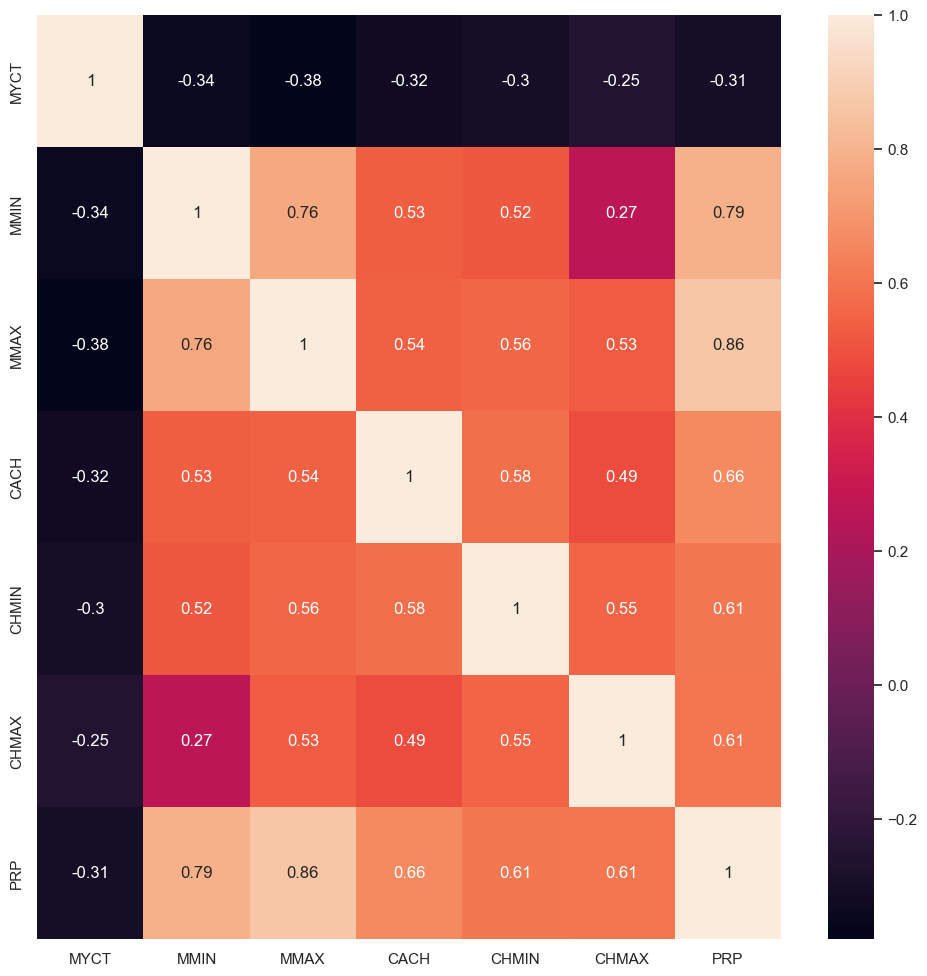

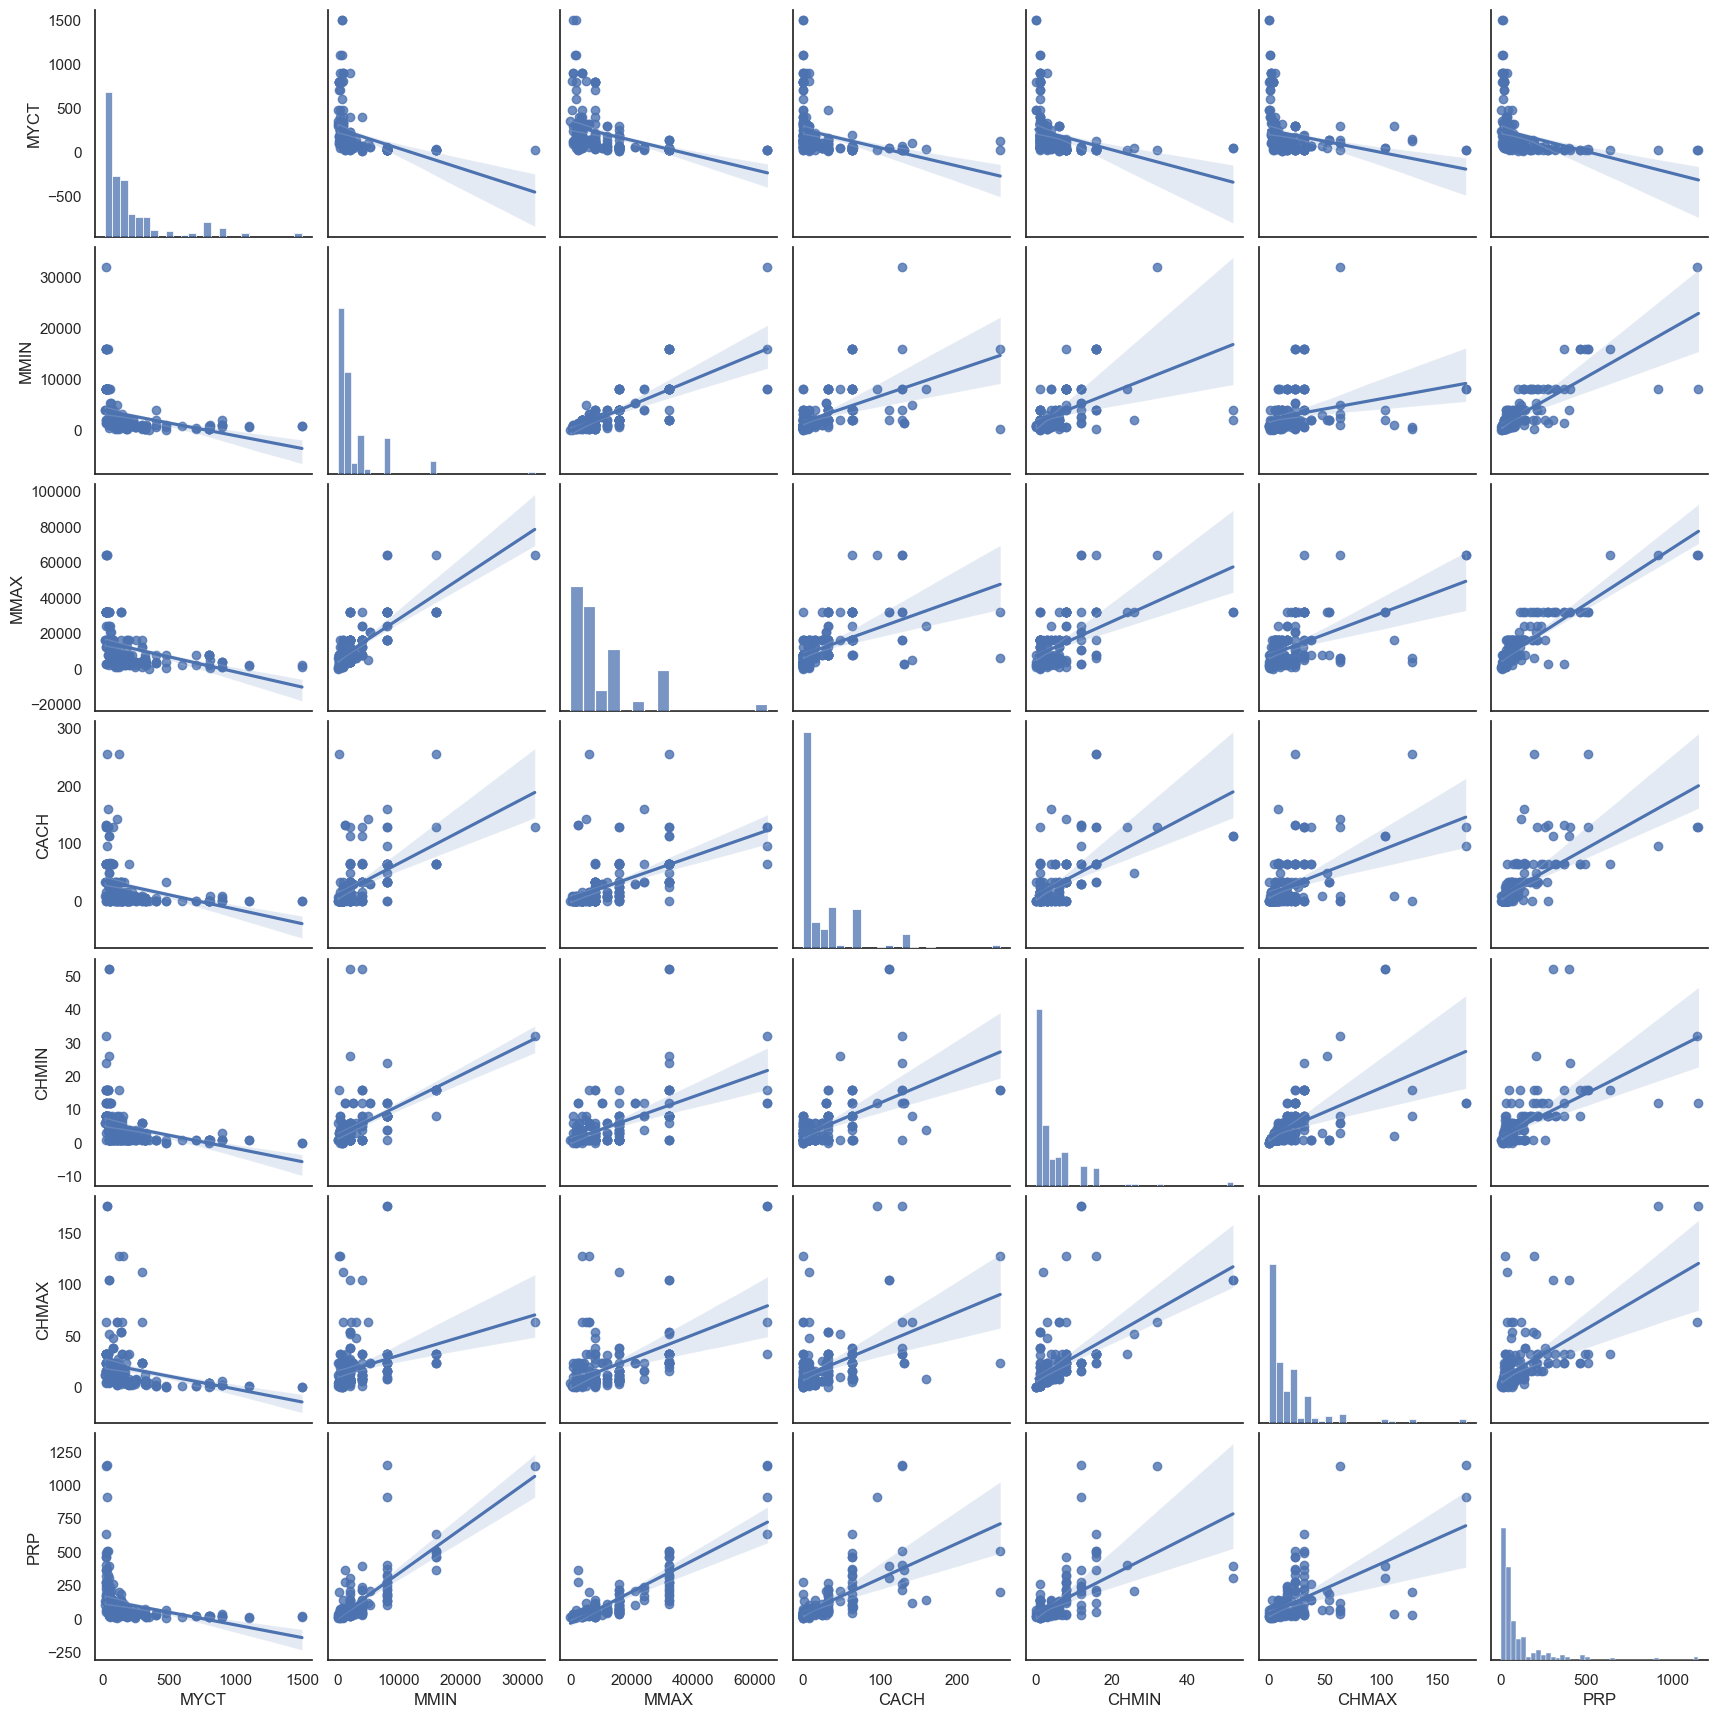

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# 필요한 피처 선택
features = dt.columns[2:9]

# 상관 행렬 및 시각화
cor = dt[features].corr()
sns.set(style='white')
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cor, annot=True)
plt.show()

sns.pairplot(dt[features], kind='reg')
plt.show()


In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 데이터 정규화
scaler = MinMaxScaler()
dt_scaled = scaler.fit_transform(dt[features])
dt_scaled = pd.DataFrame(dt_scaled, columns=features)

# 훈련 데이터와 테스트 데이터 분리
X = dt_scaled[features[:-1]]
y = dt_scaled['PRP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

print('train data 개수: ', len(X_train))
print('test data 개수: ', len(X_test))


train data 개수:  146
test data 개수:  63


Cross-Validation RMSE scores: [0.21164906 0.28367681 0.19838803 0.27529504 0.27613554]
Average Cross-Validation RMSE: 0.2490288949657593
MSE (train): 0.0023666214721075863
MSE (test): 0.0039608058937335615
MAE (test): 0.030208459097094957
R^2 (test): 0.8186778775733226


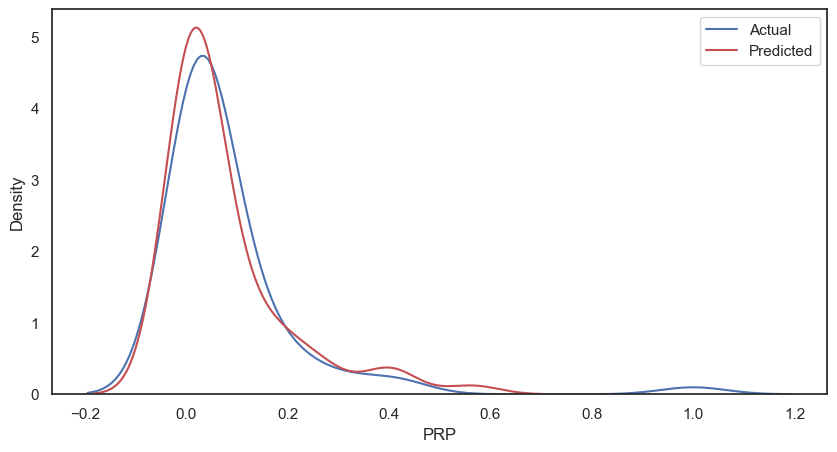

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 교차 검증
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = np.sqrt(-1 * cv_scores)
print(f'Cross-Validation RMSE scores: {rmse_scores}')
print(f'Average Cross-Validation RMSE: {rmse_scores.mean()}')

# 성능 평가
print(f'MSE (train): {mean_squared_error(y_train, y_train_pred)}')
print(f'MSE (test): {mean_squared_error(y_test, y_test_pred)}')
print(f'MAE (test): {mean_absolute_error(y_test, y_test_pred)}')
print(f'R^2 (test): {r2_score(y_test, y_test_pred)}')

# 결과 시각화
plt.figure(figsize=(10, 5))
sns.kdeplot(y_test, label="Actual", color='b')
sns.kdeplot(y_test_pred, label="Predicted", color='r')
plt.legend()
plt.show()


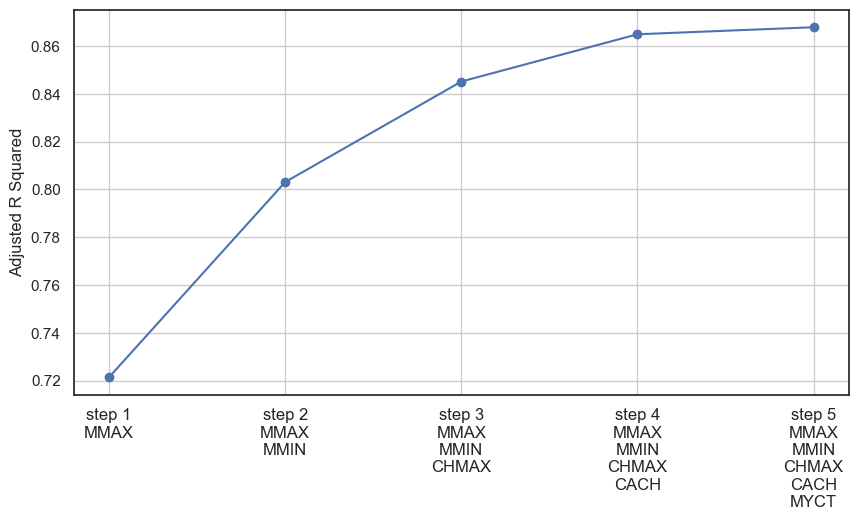

Selected variables: ['MMAX', 'MMIN', 'CHMAX', 'CACH', 'MYCT']


In [5]:
import statsmodels.api as sm

def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist()):
    import warnings
    warnings.filterwarnings("ignore")
    
    y = y_train 
    selected_variables = []  
    sl_enter = 0.05
    sl_remove = 0.05
    sv_per_step = [] 
    adjusted_r_squared = [] 
    steps = [] 
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) 
        
        for col in remainder: 
            X = X_train[selected_variables + [col]]
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit(disp=0)
            pval[col] = model.pvalues[col]
    
        min_pval = pval.min()
        if min_pval < sl_enter: 
            selected_variables.append(pval.idxmin())
            
            while len(selected_variables) > 0:
                selected_X = X_train[selected_variables]
                selected_X = sm.add_constant(selected_X)
                selected_pval = sm.OLS(y, selected_X).fit(disp=0).pvalues[1:] 
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: 
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break
            
            step += 1
            steps.append(step)
            adj_r_squared = sm.OLS(y, sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj
            adjusted_r_squared.append(adj_r_squared)
            sv_per_step.append(selected_variables.copy())
        else:
            break

    plt.figure(figsize=(10, 5))
    plt.plot(steps, adjusted_r_squared, marker='o')
    plt.xticks(steps, [f'step {s}\n' + '\n'.join(sv_per_step[i]) for i, s in enumerate(steps)], fontsize=12)
    plt.ylabel('Adjusted R Squared')
    plt.grid(True)
    plt.show()

    return selected_variables

# 단계별 변수 선택 수행
selected_variables = stepwise_feature_selection(X_train, y_train)
print(f'Selected variables: {selected_variables}')


MSE (train): 0.0023871576182094272
MSE (test): 0.0037693080596651165
MAE (test): 0.030172536123566164
R^2 (test): 0.8274444757467745


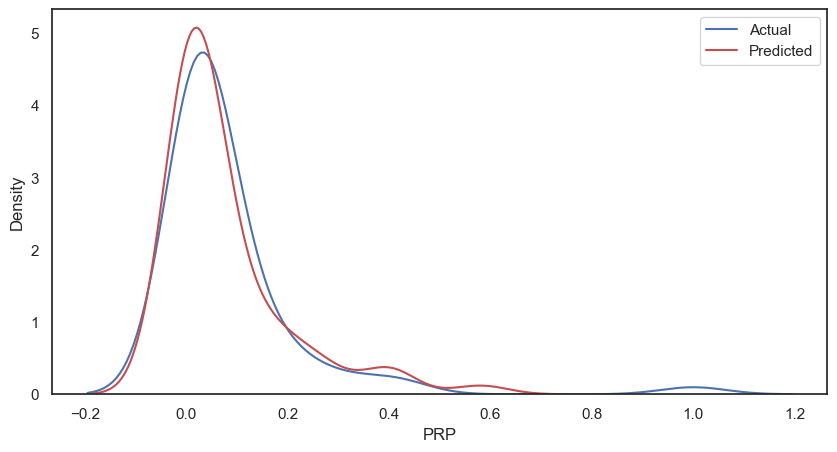

In [6]:
# 선택된 변수로 데이터셋 재구성
X_selected = dt_scaled[selected_variables]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=10)

# 모델 학습 및 예측
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 성능 평가
print(f'MSE (train): {mean_squared_error(y_train, y_train_pred)}')
print(f'MSE (test): {mean_squared_error(y_test, y_test_pred)}')
print(f'MAE (test): {mean_absolute_error(y_test, y_test_pred)}')
print(f'R^2 (test): {r2_score(y_test, y_test_pred)}')

# 결과 시각화
plt.figure(figsize=(10, 5))
sns.kdeplot(y_test, label="Actual", color='b')
sns.kdeplot(y_test_pred, label="Predicted", color='r')
plt.legend()
plt.show()
